#### [ Pytorch기반 회귀 모델 구현]
- Layer => Full-Connected Layer, Linear
- 손실함수 => MSELoss, MAELoss
- 회귀 모델, 전처리 빼고 일단 모델부터 만들기

# [1] 데이터 준비

In [1]:
import pandas as pd

# import os
# os.environ['KMP_DUPLICATE_LIB_OK']='True'

df = pd.read_csv("../../data/BostonHousing.csv")
df.head()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,b,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2


In [2]:
dataDF = df.iloc[:, :-1]
labelSR = df.iloc[:, -1]
print(dataDF.shape, labelSR.shape)

(506, 13) (506,)


# [2] 사용자 데이터셋 클래스 정의

In [3]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

In [4]:
# 클래스 정의
class BostonDS(Dataset):
  # 데이터 전처리 => 정규화
  def __init__(self, feature, target):
    super().__init__()
    self.feature = torch.FloatTensor(feature)
    self.target = torch.FloatTensor(target)
    self.length = self.feature.shape[0]
    # min-max scaler를 이 안에서 쓰고 싶다면 직접 계산해도 됨 
    self.norm_feature = self.normization()
    
    
  def __len__(self):
    return self.length
  
  def __getitem__(self, index):
    return self.feature[index], self.target[index]
  
  # 데이터 정규화 기능 함수
  def normization(self):
    self.feature.max(dim=1)

In [5]:
testDS = BostonDS(dataDF.iloc[:450, :].values, labelSR[:450].values)
valDS = BostonDS(dataDF.iloc[450:, :].values, labelSR[450:].values)

In [6]:
from torch.utils.data import DataLoader

testDL = DataLoader(testDS, batch_size=50, shuffle=True, drop_last=True)
valDL = DataLoader(valDS, batch_size=50, shuffle=True, drop_last=True)

# 데이터 학습 및 저장 

In [7]:
import torch
import torch.nn as nn # linear Regression 기능의 클래스 Linear
import torch.nn.functional as F # 손실함수를 위함
import torch.optim as optim # 최적화를 위함
from sklearn.metrics import r2_score

In [21]:
# MyModel 클래스 생성 : 내 미션은 퍼셉트론 수 영향 알아보기 
class MyModel(nn.Module):
    
    # 모델 구성 요소 초기화 
    def __init__(self, num_features):
        super().__init__() # 클래스 상속 
        self.fc1 = nn.Linear(num_features, 50) # 예측할 거니까
        self.fc2 = nn.Linear(50, 30)
        self.fc3 = nn.Linear(30, 1)
        self.dropout = nn.Dropout(0.2)
   
        
    def forward(self, x):
        # 각 레이어를 차례로 통과시킴
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = F.relu(self.fc3(x))
        return x
  

In [22]:
# 실행 디바이스 설정
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [23]:
# 모델 인스턴스 생성
import numpy as np 

model = MyModel(13).to(DEVICE)

# 손실함수 인스턴스 생성
LOSS_FN = nn.MSELoss().to(DEVICE) # 회귀 모델 

# 최적화 인스턴스 생성
OPTIMIZER = optim.Adam(model.parameters()) # lr = default 사용

# 반복 횟수
EPOCHS = 10

In [24]:
# 학습 진행 함수
def training():
    # 학습 모드 전환 함수 : dropout이나 batch normalization과 같은 레이어들이 학습할 때의 동작 모드
    model.train()
    
    # 배치크기 만큼 학습 진행 및 저장 
    train_loss = []
    train_r2 = []
    
    for cnt, (feature, target) in enumerate(testDL):

        # 배치크기만큼의 학습 데이터 준비 
        feature, target = feature.to(DEVICE), target.to(DEVICE)
        target = target.squeeze().type(torch.float32)

        # 학습 
        pre_target = model(feature)
        # 손실계산
        loss = LOSS_FN(pre_target.squeeze(), target)
        train_loss.append(loss.item())
        
        # r2 계산
        r2 = r2_score(target.detach().numpy(), pre_target.detach().numpy())
        train_r2.append(r2)
        
        # W, b 업데이트
        OPTIMIZER.zero_grad() # 초기화
        loss.backward() 
        OPTIMIZER.step()

    return np.mean(train_loss), np.mean(train_r2)

In [25]:
def testing():
    # 추론 모드 : 레이어 비활성화, 순전파만!! 수행
    model.eval()
    with torch.no_grad():
        # 배치크기 만큼 학습 진행 및 저장 
        val_loss = []
        val_r2 = []
        for cnt, (feature, target) in enumerate(valDL):
            # print(cnt, feature, target)
            # 배치크기만큼의 학습 데이터 준비 
            feature, target = feature.to(DEVICE), target.to(DEVICE)
            target = target.squeeze().type(torch.float32)
         
            pre_target = model(feature)
            
            # 손실계산
            loss = LOSS_FN(pre_target, target)
            val_loss.append(loss.item())
            
            r2 = r2_score(target.detach().numpy(), pre_target.detach().numpy())
            val_r2.append(r2)
    
    return np.mean(val_loss), np.mean(val_r2)

In [26]:
# 지정된 횟수 만큼 처음부터 ~ 끝까지 학습 및 검증 진행 
# 목표 : 최적(Error 최소화)의 W, b를 가진 모델 완성 

# from torch.optim.lr_scheduler import ReduceLROnPlateau
test_val_loss = [[],[]]
test_val_r2 = [[],[]]

for eps in range(EPOCHS):
    train_loss= training() # 학습
    test_val_loss[0].append(train_loss[0])
    test_val_r2[0].append(train_loss[1])
    
    valid_loss = testing() # 검증 
    test_val_loss[1].append(valid_loss[0])
    test_val_r2[1].append(valid_loss[1])
    
    # print(f"[{eps}/{EPOCHS}] \nTRAIN {sum(train_loss)/len(train_loss)} \nVALID : {sum(valid_loss)/len(valid_loss)}\n\n")
    print(eps, f"improve_cnt => {eps+1}")
    

c:\Users\kdp\anaconda3\envs\TORCH_NLP38\lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([50])) that is different to the input size (torch.Size([50, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\kdp\anaconda3\envs\TORCH_NLP38\lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([50])) that is different to the input size (torch.Size([50, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\kdp\anaconda3\envs\TORCH_NLP38\lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([50])) that is different to the input size (torch.Size([50, 1])). This will likely lead to incorrect results due to broadcasting. Please ensu

0 improve_cnt => 1
1 improve_cnt => 2
2 improve_cnt => 3
3 improve_cnt => 4
4 improve_cnt => 5
5 improve_cnt => 6
6 improve_cnt => 7
7 improve_cnt => 8
8 improve_cnt => 9
9 improve_cnt => 10


c:\Users\kdp\anaconda3\envs\TORCH_NLP38\lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([50])) that is different to the input size (torch.Size([50, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


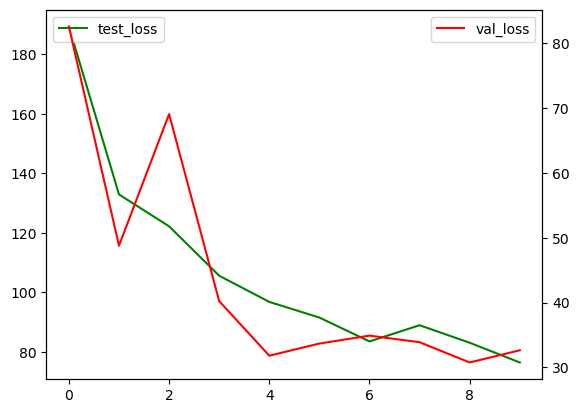

In [27]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots()
ax1.plot(test_val_loss[0], label='test_loss', color="g")

ax2 = ax1.twinx()
ax2.plot(test_val_loss[1],label='val_loss', color='r')

ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.xlabel("Epochs")
plt.show()

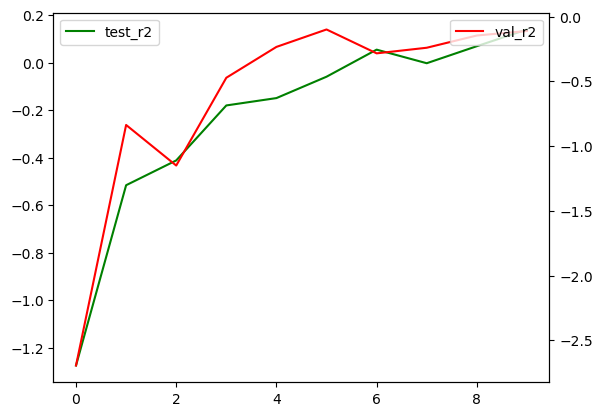

In [28]:
fig, ax1 = plt.subplots()
ax1.plot(test_val_r2[0], label='test_r2', color="g")

ax2 = ax1.twinx()
ax2.plot(test_val_r2[1],label='val_r2', color='r')

ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.xlabel("Epochs")
plt.show()

In [29]:
test_val_r2[0]

[-1.274383179799205,
 -0.516115323343018,
 -0.4118670891238285,
 -0.18056363379772128,
 -0.14962369493638655,
 -0.059710824839528165,
 0.05415032627404142,
 -0.0029981100558996105,
 0.06869934634923003,
 0.13898014429893252]

In [30]:
test_val_r2[1]

[-2.693279690379003,
 -0.8364980891649358,
 -1.1497571280047785,
 -0.4719938435911979,
 -0.23390619613977015,
 -0.09935515865477029,
 -0.28367853056322945,
 -0.2403891391539874,
 -0.14587125256690947,
 -0.11114734496155942]